# CycleGAN
- Theory: [A Gentle Introduction to CycleGAN for Image Translation](https://machinelearningmastery.com/what-is-cyclegan/)
- Building blocks of the implementation step by step implementation: [How to Implement CycleGAN Models From Scratch With Keras](https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/)
- All together [How to Develop a CycleGAN for Image-to-Image Translation with Keras](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/)

# How to Develop a CycleGAN for Image-to-Image Translation with Keras

The Cycle Generative Adversarial Network, or CycleGAN, is an approach to training a deep convolutional neural network for image-to-image translation tasks.

Unlike other GAN models for image translation, the CycleGAN does not require a dataset of paired images. For example, if we are interested in translating photographs of oranges to apples, we do not require a training dataset of oranges that have been manually converted to apples. This allows the development of a translation model on problems where training datasets may not exist, such as translating paintings to photographs.

In this tutorial, you will discover how to develop a CycleGAN model to translate photos of horses to zebras, and back again.

After completing this tutorial, you will know:

- How to load and prepare the horses to zebras image translation dataset for modeling.
- How to train a pair of CycleGAN generator models for translating horses to zebras and zebras to horses.
- How to load saved CycleGAN models and use them to translate photographs.

# Tutorial Overview
This tutorial is divided into four parts; they are:

# What is the CycleGAN?
- How to Prepare the Horses to Zebras Dataset
- How to Develop a CycleGAN to Translate Horses to Zebras
- How to Perform Image Translation with CycleGAN Generators

# What Is the CycleGAN?

The CycleGAN model was described by Jun-Yan Zhu, et al. in their 2017 paper titled “Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.”

The benefit of the CycleGAN model is that it can be trained without paired examples. That is, it does not require examples of photographs before and after the translation in order to train the model, e.g. photos of the same city landscape during the day and at night. Instead, the model is able to use a collection of photographs from each domain and extract and harness the underlying style of images in the collection in order to perform the translation.

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B).

- Generator-A -> Domain-A
- Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

- Domain-B -> Generator-A -> Domain-A
- Domain-A -> Generator-B -> Domain-B

Each generator has a corresponding discriminator model. The first discriminator model (Discriminator-A) takes real images from Domain-A and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B and generated images from Generator-B and predicts whether they are real or fake.

- Domain-A -> Discriminator-A -> [Real/Fake]
- Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
- Domain-B -> Discriminator-B -> [Real/Fake]
- Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]

The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models. The generators learn to better fool the discriminators and the discriminator learn to better detect fake images. Together, the models find an equilibrium during the training process.

Additionally, the generator models are regularized to not just create new images in the target domain, but instead translate more reconstructed versions of the input images from the source domain. This is achieved by using generated images as input to the corresponding generator model and comparing the output image to the original images. Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

- Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
- Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

There is one further element to the architecture, referred to as the identity mapping. This is where a generator is provided with images as input from the target domain and is expected to generate the same image without change. This addition to the architecture is optional, although results in a better matching of the color profile of the input image.

- Domain-A -> Generator-A -> Domain-A
- Domain-B -> Generator-B -> Domain-B

Now that we are familiar with the model architecture, we can take a closer look at each model in turn and how they can be implemented.

The paper provides a good description of the models and training process, although the official Torch implementation was used as the definitive description for each model and training process and provides the basis for the the model implementations described below.

How to Prepare the Horses to Zebras Dataset
One of the impressive examples of the CycleGAN in the paper was to transform photographs of horses to zebras, and the reverse, zebras to horses.

The authors of the paper referred to this as the problem of “object transfiguration” and it was also demonstrated on photographs of apples and oranges.

In this tutorial, we will develop a CycleGAN from scratch for image-to-image translation (or object transfiguration) from horses to zebras and the reverse.

We will refer to this dataset as “horses2zebra“. The zip file for this dataset about 111 megabytes and can be downloaded from the CycleGAN webpage:

[Download Horses to Zebras Dataset (111 megabytes)](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip)

Download the dataset into your current working directory.

You will see the following directory structure:

In [ ]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2020-05-02 02:37:54--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  88.8MB/s    in 1.3s    

2020-05-02 02:37:55 (88.8 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [ ]:
!unzip horse2zebra.zip
!ls

Archive:  horse2zebra.zip
   creating: horse2zebra/
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/trainA/n02381460_1666.jpg  
  inflating: horse2zebra/trainA/n02381460_4396.jpg  
  inflating: horse2zebra/trainA/n02381460_4502.jpg  
  inflating: horse2zebra/trainA/n02381460_8527.jpg  
  inflating: horse2zebra/trainA/n02381460_14.jpg  
  inflating: horse2zebra/trainA/n02381460_706.jpg  
  inflating: horse2zebra/trainA/n02381460_4019.jpg  
  inflating: horse2zebra/trainA/n02381460_1478.jpg  
  inflating: horse2zebra/trainA/n02381460_3449.jpg  
  inflating: horse2zebra/trainA/n02381460_5558.jpg  
  inflating: horse2zebra/trainA/n02381460_969.jpg  
  inflating: horse2

The “A” category refers to horse and “B” category refers to zebra, and the dataset is comprised of train and test elements. We will load all photographs and use them as a training dataset.

The photographs are square with the shape 256×256 and have filenames like “n02381460_2.jpg“.

The example below will load all photographs from the train and test folders and create an array of images for category A and another for category B.

Both arrays are then saved to a new file in compressed NumPy array format.

In [ ]:
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = 'horse2zebra/'
# load dataset A
dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'horse2zebra_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Using TensorFlow backend.


Loaded dataA:  (1187, 256, 256, 3)
Loaded dataB:  (1474, 256, 256, 3)
Saved dataset:  horse2zebra_256.npz


Running the example first loads all images into memory, showing that there are 1,187 photos in category A (horses) and 1,474 in category B (zebras).

The arrays are then saved in compressed NumPy format with the filename “horse2zebra_256.npz“. Note: this data file is about 570 megabytes, larger than the raw images as we are storing pixel values as 32-bit floating point values.

We can then load the dataset and plot some of the photos to confirm that we are handling the image data correctly.

Loaded:  (1187, 256, 256, 3) (1474, 256, 256, 3)


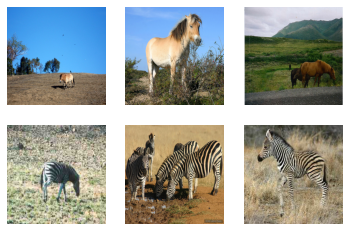

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('horse2zebra_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

Now that we have prepared the dataset for modeling, we can develop the CycleGAN generator models that can translate photos from one category to the other, and the reverse.

# How to Develop a CycleGAN to Translate Horse to Zebra
In this section, we will develop the CycleGAN model for translating photos of horses to zebras and photos of zebras to horses

The same model architecture and configuration described in the paper was used across a range of image-to-image translation tasks. This architecture is both described in the body paper, with additional detail in the appendix of the paper, and a fully working implementation provided as open source implemented for the Torch deep learning framework.

The implementation in this section will use the Keras deep learning framework based directly on the model described in the paper and implemented in the author’s codebase, designed to take and generate color images with the size 256×256 pixels.

The architecture is comprised of four models, two discriminator models, and two generator models.

The discriminator is a deep convolutional neural network that performs image classification. It takes a source image as input and predicts the likelihood of whether the target image is a real or fake image. Two discriminator models are used, one for Domain-A (horses) and one for Domain-B (zebras).

The discriminator design is based on the effective receptive field of the model, which defines the relationship between one output of the model to the number of pixels in the input image. This is called a PatchGAN model and is carefully designed so that each output prediction of the model maps to a 70×70 square or patch of the input image. The benefit of this approach is that the same model can be applied to input images of different sizes, e.g. larger or smaller than 256×256 pixels.

The output of the model depends on the size of the input image but may be one value or a square activation map of values. Each value is a probability for the likelihood that a patch in the input image is real. These values can be averaged to give an overall likelihood or classification score if needed.

A pattern of Convolutional-BatchNorm-LeakyReLU layers is used in the model, which is common to deep convolutional discriminator models. Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization. It is a very simple type of normalization and involves standardizing (e.g. scaling to a standard Gaussian) the values on each output feature map, rather than across features in a batch.

An implementation of instance normalization is provided in the keras-contrib project that provides early access to community supplied Keras features.

The keras-contrib library can be installed via pip as follows:

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-yqskvdbx
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-yqskvdbx
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=70c47874e697c0e75ecc454854bdcf2d1efe45d2117d9671fa6e26fe9706a5b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-lehlu_5v/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


The new InstanceNormalization layer can then be used as follows:
```
...
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)
...
```
The “axis” argument is set to -1 to ensure that features are normalized per feature map.

# D

The define_discriminator() function below implements the 70×70 PatchGAN discriminator model as per the design of the model in the paper. The model takes a 256×256 sized image as input and outputs a patch of predictions. The model is optimized using least squares loss (L2) implemented as mean squared error, and a weighting it used so that updates to the model have half (0.5) the usual effect. The authors of CycleGAN paper recommend this weighting of model updates to slow down changes to the discriminator, relative to the generator model during training.


In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# G
The generator model is more complex than the discriminator model.

The generator is an encoder-decoder model architecture. The model takes a source image (e.g. horse photo) and generates a target image (e.g. zebra photo). It does this by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections, followed by a series of layers that upsample or decode the representation to the size of the output image.

First, we need a function to define the ResNet blocks. These are blocks comprised of two 3×3 CNN layers where the input to the block is concatenated to the output of the block, channel-wise.

This is implemented in the resnet_block() function that creates two Convolution-InstanceNorm blocks with 3×3 filters and 1×1 stride and without a ReLU activation after the second block, matching the official Torch implementation in the build_conv_block() function. Same padding is used instead of reflection padded recommended in the paper for simplicity.

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

Next, we can define a function that will create the 9-resnet block version for 256×256 input images. This can easily be changed to the 6-resnet block version by setting image_shape to (128x128x3) and n_resnet function argument to 6.

Importantly, the model outputs pixel values with the shape as the input and pixel values are in the range [-1, 1], typical for GAN generator models.

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# CycleGAN

The discriminator models are trained directly on real and generated images, whereas the generator models are not.

Instead, the generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as “real“, called adversarial loss. As such, they are encouraged to generate images that better fit into the target domain.

The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

Altogether, each generator model is optimized via the combination of four outputs with four loss functions:

Adversarial loss (L2 or mean squared error).
Identity loss (L1 or mean absolute error).
Forward cycle loss (L1 or mean absolute error).
Backward cycle loss (L1 or mean absolute error).
This can be achieved by defining a composite model used to train each generator model that is responsible for only updating the weights of that generator model, although it is required to share the weights with the related discriminator model and the other generator model.

This is implemented in the define_composite_model() function below that takes a defined generator model (g_model_1) as well as the defined discriminator model for the generator models output (d_model) and the other generator model (g_model_2). The weights of the other models are marked as not trainable as we are only interested in updating the first generator model, i.e. the focus of this composite model.

The discriminator is connected to the output of the generator in order to classify generated images as real or fake. A second input for the composite model is defined as an image from the target domain (instead of the source domain), which the generator is expected to output without translation for the identity mapping. Next, forward cycle loss involves connecting the output of the generator to the other generator, which will reconstruct the source image. Finally, the backward cycle loss involves the image from the target domain used for the identity mapping that is also passed through the other generator whose output is connected to our main generator as input and outputs a reconstructed version of that image from the target domain.

To summarize, a composite model has two inputs for the real photos from Domain-A and Domain-B, and four outputs for the discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

Only the weights of the first or main generator model are updated for the composite model and this is done via the weighted sum of all loss functions. The cycle loss is given more weight (10-times) than the adversarial loss as described in the paper, and the identity loss is always used with a weighting half that of the cycle loss (5-times), matching the official implementation source code.

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

We need to create a composite model for each generator model, e.g. the Generator-A (BtoA) for zebra to horse translation, and the Generator-B (AtoB) for horse to zebra translation.

All of this forward and backward across two domains gets confusing. Below is a complete listing of all of the inputs and outputs for each of the composite models. Identity and cycle loss are calculated as the L1 distance between the input and output image for each sequence of translations. Adversarial loss is calculated as the L2 distance between the model output and the target values of 1.0 for real and 0.0 for fake.

## Generator-A Composite Model (BtoA or Zebra to Horse)

The inputs, transformations, and outputs of the model are as follows:

- Adversarial Loss: Domain-B -> Generator-A -> Domain-A -> Discriminator-A -> [real/fake]
- Identity Loss: Domain-A -> Generator-A -> Domain-A
- Forward Cycle Loss: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
- Backward Cycle Loss: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

We can summarize the inputs and outputs as:

- Inputs: Domain-B, Domain-A
- Outputs: Real, Domain-A, Domain-B, Domain-A


## Generator-B Composite Model (AtoB or Horse to Zebra)

The inputs, transformations, and outputs of the model are as follows:

- Adversarial Loss: Domain-A -> Generator-B -> Domain-B -> Discriminator-B -> [real/fake]
- Identity Loss: Domain-B -> Generator-B -> Domain-B
- Forward Cycle Loss: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A
- Backward Cycle Loss: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
We can summarize the inputs and outputs as:

- Inputs: Domain-A, Domain-B
- Outputs: Real, Domain-B, Domain-A, Domain-B

Defining the models is the hard part of the CycleGAN; the rest is standard GAN training and relatively straightforward.

# Data prep
Next, we can load our paired images dataset in compressed NumPy array format. This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

Each training iteration we will require a sample of real images from each domain as input to the discriminator and composite generator models. This can be achieved by selecting a random batch of samples.

The generate_real_samples() function below implements this, taking a NumPy array for a domain as input and returning the requested number of randomly selected images, as well as the target for the PatchGAN discriminator model indicating the images are real (target=1.0). As such, the shape of the PatchgAN output is also provided, which in the case of 256×256 images will be 16, or a 16x16x1 activation map, defined by the patch_shape function argument.

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

Similarly, a sample of generated images is required to update each discriminator model in each training iteration.

The generate_fake_samples() function below generates this sample given a generator model and the sample of real images from the source domain. Again, target values for each generated image are provided with the correct shape of the PatchGAN, indicating that they are fake or generated (target=0.0).

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

Typically, GAN models do not converge; instead, an equilibrium is found between the generator and discriminator models. As such, we cannot easily judge whether training should stop. Therefore, we can save the model and use it to generate sample image-to-image translations periodically during training, such as every one or five training epochs.

We can then review the generated images at the end of training and use the image quality to choose a final model.

The save_models() function below will save each generator model to the current directory in H5 format, including the training iteration number in the filename. This will require that the h5py library is installed.

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

The summarize_performance() function below uses a given generator model to generate translated versions of a few randomly selected source photographs and saves the plot to file.

The source images are plotted on the first row and the generated images are plotted on the second row. Again, the plot filename includes the training iteration number.

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

We are nearly ready to define the training of the models.

The discriminator models are updated directly on real and generated images, although in an effort to further manage how quickly the discriminator models learn, a pool of fake images is maintained.

The paper defines an image pool of 50 generated images for each discriminator model that is first populated and probabilistically either adds new images to the pool by replacing an existing image or uses a generated image directly. We can implement this as a Python list of images for each discriminator and use the update_image_pool() function below to maintain each pool list.

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

We can now define the training of each of the generator models.

The train() function below takes all six models (two discriminator, two generator, and two composite models) as arguments along with the dataset and trains the models.

The batch size is fixed at one image to match the description in the paper and the models are fit for 100 epochs. Given that the horses dataset has 1,187 images, one epoch is defined as 1,187 batches and the same number of training iterations. Images are generated using both generators each epoch and models are saved every five epochs or (1187 * 5) 5,935 training iterations.

The order of model updates is implemented to match the official Torch implementation. First, a batch of real images from each domain is selected, then a batch of fake images for each domain is generated. The fake images are then used to update each discriminator’s fake image pool.

Next, the Generator-A model (zebras to horses) is updated via the composite model, followed by the Discriminator-A model (horses). Then the Generator-B (horses to zebra) composite model and Discriminator-B (zebras) models are updated.

Loss for each of the updated models is then reported at the end of the training iteration. Importantly, only the weighted average loss used to update each generator is reported.

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 1, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

Tying all of this together, the complete example of training a CycleGAN model to translate photos of horses to zebras and zebras to horses is listed below.

In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# load image data
dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[1.173,0.821] dB[1.130,0.833] g[20.229,19.996]
>2, dA[2.566,0.901] dB[1.372,1.627] g[17.722,18.335]
>3, dA[1.087,1.169] dB[0.945,2.173] g[18.753,18.892]
>4, dA[3.209,2.101] dB[1.084,1.376] g[17.571,17.853]
>5, dA[4.159,1.395] dB[0.884,3.000] g[17.875,16.390]
>6, dA[2.675,1.102] dB[1.226,2.210] g[14.067,15.491]
>7, dA[3.067,1.828] dB[1.044,2.440] g[16.478,17.151]
>8, dA[2.649,2.362] dB[0.954,4.625] g[16.983,14.337]
>9, dA[4.975,0.970] dB[0.995,1.625] g[16.588,15.673]
>10, dA[4.182,1.190] dB[0.900,4.170] g[21.644,17.667]
>11, dA[2.120,0.821] dB[2.312,2.060] g[14.578,12.902]
>12, dA[2.007,0.956] dB[1.105,2.570] g[14.651,12.660]
>13, dA[0.665,1.108] dB[0.796,1.408] g[13.515,13.220]
>14, dA[1.029,1.081] dB[0.667,1.256] g[14.247,15.262]
>15, dA[0.916,0.628] dB[0.774,0.775] g[10.278,11.335]
>16, dA[0.558,0.516] dB[0.748,0.777] g[14.094,14.051]
>17, dA[1.026,0.480] dB[0.717,0.856] g[11.903,11.730]
>18, dA[0.461,0.481] dB[0.469,0.811] g[12.690,11.491]
>19, dA[0.445,0.363] dB[0.428,0.643] 

The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

If loss for the discriminator goes to zero and stays there for a long time, consider re-starting the training run as it is an example of a training failure.

Now that we have fit our CycleGAN generators, we can use them to translate photographs in an ad hoc manner.

# How to Perform Image Translation With CycleGAN Generators
The saved generator models can be loaded and used for ad hoc image translation.

The first step is to load the dataset. We can use the same load_real_samples() function as we developed in the previous section.

Review the plots of generated images and select a pair of models that we can use for image generation. In this case, we will use the model saved around epoch 89 (training iteration 89,025). Our generator models used a custom layer from the keras_contrib library, specifically the InstanceNormalization layer. Therefore, we need to specify how to load this layer when loading each generator model.

This can be achieved by specifying a dictionary mapping of the layer name to the object and passing this as an argument to the load_model() keras function.

We can use the select_sample() function that we developed in the previous section to select a random photo from the dataset.

Next, we can use the Generator-AtoB model, first by selecting a random image from Domain-A (horses) as input, using Generator-AtoB to translate it to Domain-B (zebras), then use the Generator-BtoA model to reconstruct the original image (horse).

We can then plot the three photos side by side as the original or real photo, the translated photo, and the reconstruction of the original photo. The show_plot() function below implements this.

We can then call this function to plot our real and generated photos.

This is a good test of both models, however, we can also perform the same operation in reverse.

Specifically, a real photo from Domain-B (zebra) translated to Domain-A (horse), then reconstructed as Domain-B (zebra).

Tying all of this together, the complete example is listed below.

In [ ]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
A_data, B_data = load_real_samples('horse2zebra_256.npz')
print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_089025.h5', cust)
model_BtoA = load_model('g_model_BtoA_089025.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)


OSError: ignored

We can develop a function to load this image and scale it to the preferred size of 256×256, scale pixel values to the range [-1,1], and convert the array of pixels to a single sample.

The load_image() function below implements this.

In [ ]:
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

We can then load our selected image as well as the AtoB generator model, as we did before.

We can then translate the loaded image, scale the pixel values back to the expected range, and plot the result.

Tying this all together, the complete example is listed below.

In [ ]:
# example of using saved cyclegan models for image translation
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot



# load the image
image_src = load_image('horse2zebra/trainA/n02381460_541.jpg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_100895.h5', cust)
# translate image
image_tar = model_AtoB.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()